----

In [1]:
!pip install fastai --upgrade
!pip install timm

In [1]:
import torch
from fastai.vision.all import *
import numpy as np
import os
from pathlib import Path
import timm

In [2]:
# Define paths
x = '/kaggle/input/splitrealwaste/realwaste-main/RealWaste'
path = Path(x)
path.ls()

np.random.seed(40)

In [3]:
# Define DataLoaders for swin (224x224) and DINO (224x224)
# validation is 17.58% because it is splitting from the remaining 85% 
# after the test dataset is already separated before the data is loaded.
data_swin = ImageDataLoaders.from_folder(path, train='.', valid_pct=0.1758,
                                              item_tfms=Resize(224),
                                              batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
                                              num_workers=4)

data_dino = ImageDataLoaders.from_folder(path, train='.', valid_pct=0.1758,
                                         item_tfms=Resize(224),
                                         batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
                                         num_workers=4)

In [4]:
# Train swin V4 model
swin = timm.create_model('swin_base_patch4_window7_224.ms_in22k_ft_in1k', pretrained=True)
swin.reset_classifier(0)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [6]:
# Define a custom head for swin V4
class SwinHead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.head = nn.Linear(swin.num_features, num_classes)
        
    def forward(self, x):
        x = swin(x)
        x = self.head(x)
        return x

# Create a Learner for swin v4

swin_learner = Learner(data_swin, SwinHead(len(data_swin.vocab)), metrics=accuracy,  model_dir=Path('/kaggle/working/'))

swin_learner.model.swin = swin

In [7]:
#swin_learner.recorder.lr_find()
#swin_learner.recorder.plot_lr_find()

In [7]:
lr_min = 1e-5
lr_ideal = 3e-5
swin_learner.fit_one_cycle(13, slice(lr_min, lr_ideal))
swin_learner.save('swin')

epoch,train_loss,valid_loss,accuracy,time
0,2.084833,1.895486,0.323944,01:13
1,1.414409,0.587177,0.818310,01:11
2,0.735005,0.294385,0.900000,01:11
3,0.376643,0.236450,0.916901,01:11
4,0.219089,0.202454,0.938028,01:11
5,0.128693,0.184352,0.945070,01:11
6,0.074869,0.145828,0.950704,01:12
7,0.046707,0.164557,0.953521,01:11
8,0.030129,0.172994,0.947887,01:12
9,0.020475,0.167025,0.950704,01:11


Path('/kaggle/working/swin.pth')

In [8]:
swin_learner.unfreeze()
swin_learner.fit_one_cycle(5, slice(lr_min / 10, lr_ideal / 10))
swin_learner.save('swin_finetuned')

epoch,train_loss,valid_loss,accuracy,time
0,0.011755,0.176305,0.952113,01:12
1,0.011452,0.174469,0.950704,01:12
2,0.011611,0.179234,0.952113,01:12
3,0.010190,0.177247,0.950704,01:11
4,0.009946,0.176900,0.952113,01:11


Path('/kaggle/working/swin_finetuned.pth')

In [9]:
# Train DINO model
vitb16 = timm.create_model('vit_base_patch16_224.dino', pretrained=True)
vitb16.head = nn.Identity()

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [10]:
# Define a custom head for DINO
class DinoHead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.head = nn.Linear(vitb16.num_features, num_classes)
        
    def forward(self, x):
        x = vitb16(x)
        x = self.head(x)
        return x

# Create a Learner for DINO
dino_learner = Learner(data_dino, DinoHead(len(data_dino.vocab)), metrics=accuracy,  model_dir=Path('/kaggle/working/'))
dino_learner.model.vitb16 = vitb16
lr1 = 1e-5
lr2 = 1e-4
dino_learner.fit_one_cycle(25, slice(lr1, lr2))


epoch,train_loss,valid_loss,accuracy,time
0,1.508836,0.798525,0.742254,01:07
1,0.743049,0.325547,0.891549,01:07
2,0.381725,0.215438,0.928169,01:07
3,0.221769,0.244866,0.908451,01:08
4,0.177536,0.349595,0.894366,01:08
5,0.173965,0.450353,0.864789,01:08
6,0.146904,0.347404,0.902817,01:08
7,0.113497,0.339509,0.904225,01:08
8,0.107694,0.367344,0.908451,01:07
9,0.081897,0.273259,0.932394,01:07


In [11]:
dino_learner.save('dino_model')
dino_learner.unfreeze()
dino_learner.fit_one_cycle(10, slice(1e-6, lr1))
dino_learner.save('dino_model_finetuned')

epoch,train_loss,valid_loss,accuracy,time
0,0.000134,0.200855,0.940845,01:08
1,0.000102,0.184660,0.942254,01:08
2,0.000100,0.177893,0.949296,01:08
3,0.000067,0.175801,0.950704,01:08
4,0.000097,0.176384,0.953521,01:08
5,0.000054,0.173966,0.952113,01:07
6,0.000041,0.169516,0.953521,01:07
7,0.000047,0.171221,0.953521,01:07
8,0.000035,0.170034,0.953521,01:07
9,0.000030,0.170015,0.953521,01:08


Path('/kaggle/working/dino_model_finetuned.pth')

In [13]:
# Load the fine-tuned models
swin_learner.load('swin_finetuned')
dino_learner.load('dino_model_finetuned')

# Define paths for the test dataset
test_path = Path('/kaggle/input/splitrealwaste/realwaste-main/realwaste-test')

# Create test DataLoaders for swin v4 and DINO
test_dl_swin = swin_learner.dls.test_dl(get_image_files(test_path), with_labels=True, item_tfms=Resize(299))
test_dl_dino = dino_learner.dls.test_dl(get_image_files(test_path), with_labels=True, item_tfms=Resize(224))

# Validate swin v4 model
val_loss_swin, val_acc_swin = swin_learner.validate(dl=data_swin.valid)
print(f'Swin Validation Accuracy: {val_acc_swin:.4f}')

# Validate DINO model
val_loss_dino, val_acc_dino = dino_learner.validate(dl=data_dino.valid)
print(f'DINO Validation Accuracy: {val_acc_dino:.4f}')

# Define a function to get the predictions from both models and average them
def get_ensemble_predictions(learners, dls):
    preds = []
    targets = None
    for learner, dl in zip(learners, dls):
        pred, targ = learner.get_preds(dl=dl)
        preds.append(pred)
        if targets is None:
            targets = targ
    avg_preds = torch.stack(preds).mean(0)
    return avg_preds, targets



# Get ensemble test predictions
ensemble_test_preds, test_targs = get_ensemble_predictions([swin_learner, dino_learner], [test_dl_swin, test_dl_dino])
test_acc_ensemble = accuracy(ensemble_test_preds, test_targs).item()
print(f'Ensemble Test Accuracy: {test_acc_ensemble:.4f}')

# Validate and get test accuracy for individual models
test_loss_swin, test_acc_swin = swin_learner.validate(dl=test_dl_swin)
print(f'Swin Test Accuracy: {test_acc_swin:.4f}')

test_loss_dino, test_acc_dino = dino_learner.validate(dl=test_dl_dino)
print(f'DINO Test Accuracy: {test_acc_dino:.4f}')



Swin Validation Accuracy: 0.9521


DINO Validation Accuracy: 0.9535


Ensemble Test Accuracy: 0.9549


Swin Test Accuracy: 0.9437


DINO Test Accuracy: 0.9310


<a href="#top" class="btn btn-success btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOP</a>

In [15]:
# Define the mapping for recyclable and non-recyclable labels
recyclable_labels = ['Metal', 'Plastic', 'Glass', 'Paper', 'Cardboard']

# Function to map predicted classes to recyclable and non-recyclable
def map_to_recyclable(prediction):
    return 'Recyclable' if prediction in recyclable_labels else 'Non-Recyclable'

# Get predictions for the test set from the ensemble
test_preds, test_targs = get_ensemble_predictions([swin_learner, dino_learner], [test_dl_swin, test_dl_dino])
test_preds_classes = torch.argmax(test_preds, dim=1)
test_preds_labels = [swin_learner.dls.vocab[pred] for pred in test_preds_classes]

# Map predictions to recyclable and non-recyclable
mapped_test_preds = [map_to_recyclable(label) for label in test_preds_labels]

# Map true labels to recyclable and non-recyclable
test_targs_labels = [swin_learner.dls.vocab[label] for label in test_targs]
mapped_test_true = [map_to_recyclable(label) for label in test_targs_labels]

# Calculate accuracy
accuracy_recyclable_test = np.mean([pred == true for pred, true in zip(mapped_test_preds, mapped_test_true)])
print(f'Test Accuracy (Recyclable vs Non-Recyclable): {accuracy_recyclable_test:.4f}')

Test Accuracy (Recyclable vs Non-Recyclable): 0.9873


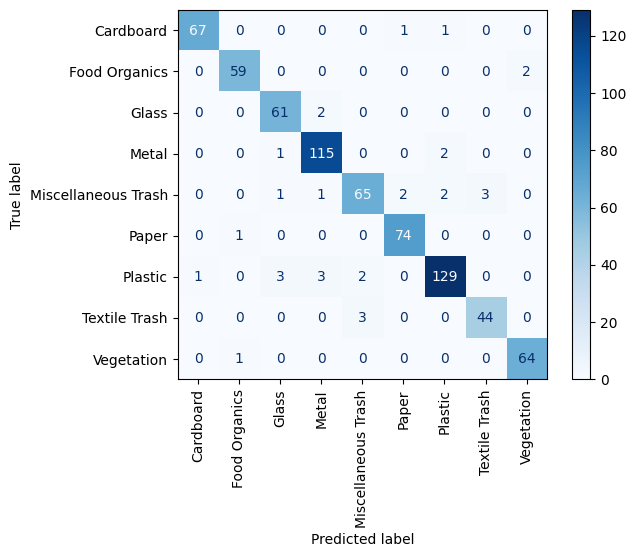

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(include_values=True, cmap=plt.cm.Blues, ax=None, xticks_rotation='vertical')
    plt.show()

# Get the true labels and predicted labels for the test set
y_true = np.array([test_dl_swin.dataset[i][1] for i in range(len(test_dl_swin.dataset))])
y_pred = ensemble_test_preds.argmax(dim=1).numpy()

# Plot confusion matrix for test set
plot_confusion_matrix(y_true, y_pred, classes=data_swin.vocab)